# Описание проекта
Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.
# Описание тарифов
Тариф «Смарт»
Ежемесячная плата: 550 рублей
Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
Стоимость услуг сверх тарифного пакета:
минута разговора: 3 рубля
сообщение: 3 рубля
1 Гб интернет-трафика: 200 рублей

Тариф «Ультра»
Ежемесячная плата: 1950 рублей
Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
Стоимость услуг сверх тарифного пакета:
минута разговора: 1 рубль
сообщение: 1 рубль
1 Гб интернет-трафика: 150 рублей

# Описание данных
Таблица users (информация о пользователях):

user_id — уникальный идентификатор пользователя

first_name — имя пользователя

last_name — фамилия пользователя

age — возраст пользователя (годы)

reg_date — дата подключения тарифа (день, месяц, год)

churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)

city — город проживания пользователя

tariff — название тарифного плана

Таблица calls (информация о звонках):

id — уникальный номер звонка

call_date — дата звонка

duration — длительность звонка в минутах

user_id — идентификатор пользователя, сделавшего звонок

Таблица messages (информация о сообщениях):

id — уникальный номер сообщения

message_date — дата сообщения

user_id — идентификатор пользователя, отправившего сообщение

Таблица internet (информация об интернет-сессиях):

id — уникальный номер сессии

mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)

session_date — дата интернет-сессии

user_id — идентификатор пользователя

Таблица tariffs (информация о тарифах):

tariff_name — название тарифа

rub_monthly_fee — ежемесячная абонентская плата в рублях

minutes_included — количество минут разговора в месяц, включённых в абонентскую плату

messages_included — количество сообщений в месяц, включённых в абонентскую плату

mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)

rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)

rub_per_message — стоимость отправки сообщения сверх тарифного пакета

rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

Этап 1. Осмотр и обработка данных

In [1]:
import pandas as pd
from scipy import stats as st
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display
from pymystem3 import Mystem
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns
import math
import os
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
# Подгрузим датасеты
user = pd.read_csv('/datasets/users.csv')
call = pd.read_csv('/datasets/calls.csv')
mess = pd.read_csv('/datasets/messages.csv')
inter = pd.read_csv('/datasets/internet.csv')
tarif = pd.read_csv('/datasets/tariffs.csv')

Оценим количество строк и столбцов в таблице

In [3]:
display(call.shape)
display(inter.shape)
display(mess.shape)
display(tarif.shape)
user.shape

(202607, 4)

(149396, 5)

(123036, 3)

(2, 8)

(500, 8)

In [4]:
def total_info(data):
    for info in ['columns','head()','info()','duplicated().sum()','isnull().sum()','isna().sum()']:
        return display(data.info)

In [5]:
def total_info(data):
    display(data.columns)
    display(data.head())
    display(data.info())
    display(data.duplicated().sum())
    display(data.isna().sum())

In [6]:
total_info(call)

Index(['id', 'call_date', 'duration', 'user_id'], dtype='object')

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


None

0

id           0
call_date    0
duration     0
user_id      0
dtype: int64

In [7]:
display(call.columns) # название колонок
display(call.head())# структуру таблицы
display(call.info())# состав таблицы, формат столбцов, наличие пустых строк
display(call.duplicated().sum()) # наличие дубликатов
display(call.isnull().sum()) # наличие нулевых обьектов
display(call.isna().sum())# наличие пропусков

Index(['id', 'call_date', 'duration', 'user_id'], dtype='object')

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


None

0

id           0
call_date    0
duration     0
user_id      0
dtype: int64

id           0
call_date    0
duration     0
user_id      0
dtype: int64

# информация о траффике интернета

In [8]:
display(inter.columns)
display(inter.head())
display(inter.info())
display(inter.duplicated().sum())
display(inter.isnull().sum())
display(inter.isna().sum())

Index(['Unnamed: 0', 'id', 'mb_used', 'session_date', 'user_id'], dtype='object')

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


None

0

Unnamed: 0      0
id              0
mb_used         0
session_date    0
user_id         0
dtype: int64

Unnamed: 0      0
id              0
mb_used         0
session_date    0
user_id         0
dtype: int64

# информация о сообщениях

In [9]:
display(mess.columns)
display(mess.head())
display(mess.info())
display(mess.duplicated().sum())
display(mess.isnull().sum())

Index(['id', 'message_date', 'user_id'], dtype='object')

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


None

0

id              0
message_date    0
user_id         0
dtype: int64

# информация о тарифах

In [10]:
display(tarif.columns)
display(tarif.head())
display(tarif.info())
display(tarif.duplicated().sum())
display(mess.isnull().sum())

Index(['messages_included', 'mb_per_month_included', 'minutes_included', 'rub_monthly_fee', 'rub_per_gb', 'rub_per_message', 'rub_per_minute', 'tariff_name'], dtype='object')

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


None

0

id              0
message_date    0
user_id         0
dtype: int64

# информация о пользователях

In [11]:
display(user.columns)
display(user.head())
display(user.info())
display(user.duplicated().sum())
display(user.isnull().sum())

Index(['user_id', 'age', 'churn_date', 'city', 'first_name', 'last_name', 'reg_date', 'tariff'], dtype='object')

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


None

0

user_id         0
age             0
churn_date    462
city            0
first_name      0
last_name       0
reg_date        0
tariff          0
dtype: int64

# Шаг 2. Подготовим данные

# Информация о звонках call

приводим даты к формату даты, поскольку в тарифах минуты округляются в большую сторону округляем столбец duration до целого в большую сторону

In [12]:
display(call.head())
call.info()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


приводим даты к формату даты,

In [13]:
call['call_date'] = pd.to_datetime(call['call_date'])
call.dtypes

id                   object
call_date    datetime64[ns]
duration            float64
user_id               int64
dtype: object

поменяем дату на номер месяца все равно год нам известен а число не нужно, а оперировать будет проще

In [14]:
call['call_date'] = call['call_date'].dt.month
call.head()

,id,call_date,duration,user_id
0,1000_0,7,0.00,1000
1,1000_1,8,0.00,1000
2,1000_2,6,2.85,1000
3,1000_3,9,13.80,1000
4,1000_4,12,5.18,1000


переименуем столбец с датой

In [15]:
call = call.rename(columns={"call_date": "month"})
call.head()

,id,month,duration,user_id
0,1000_0,7,0.00,1000
1,1000_1,8,0.00,1000
2,1000_2,6,2.85,1000
3,1000_3,9,13.80,1000
4,1000_4,12,5.18,1000


округляем значения столбца duration до целого в большую сторону

In [16]:
def _round(row):
    row_round = math.ceil(row)
    return row_round

In [17]:
call['duration'] = np.ceil(call['duration']).astype(int)

In [18]:
call.head()

,id,month,duration,user_id
0,1000_0,7,0,1000
1,1000_1,8,0,1000
2,1000_2,6,3,1000
3,1000_3,9,14,1000
4,1000_4,12,6,1000


In [19]:
call[call['id'] == '1000_3'] #Смотрим строку по значению

,id,month,duration,user_id
3,1000_3,9,14,1000


In [20]:
call.dtypes #Смотрим тип строк в таблице 

id          object
month        int64
duration     int64
user_id      int64
dtype: object

In [21]:
call['duration'].describe()

count    202607.000000
mean          7.158198
std           5.959173
min           0.000000
25%           2.000000
50%           6.000000
75%          11.000000
max          38.000000
Name: duration, dtype: float64

In [22]:
call.select_dtypes(include=["object", "datetime"]).describe() #Применяем .describe к нечисловым полям

,id
count,202607
unique,202607
top,1157_454
freq,1


Строим диаграмму и 2 ящика с усами

Text(0.5, 0, 'Длительность')

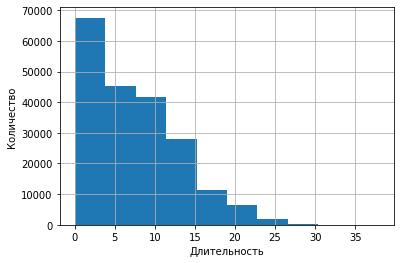

In [23]:
call['duration'].hist()
plt.ylabel('Количество')
plt.xlabel('Длительность')

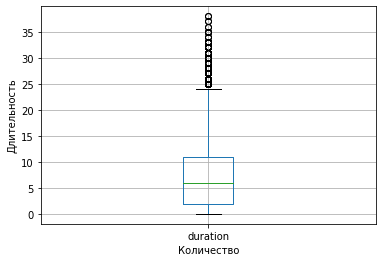

In [24]:
call.boxplot('duration')
plt.xlabel('Количество')
plt.ylabel('Длительность')
plt.show()

Text(0.5, 0, 'Длительность')

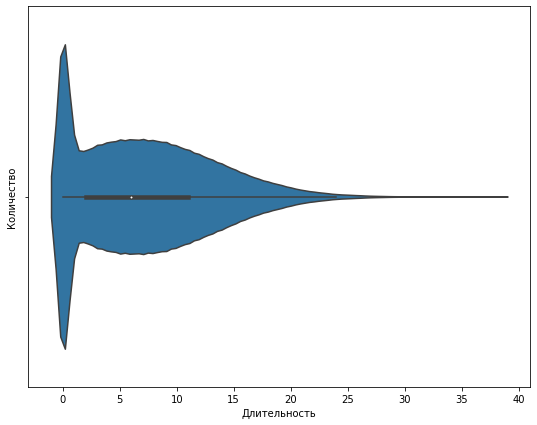

In [25]:
fig, ax = plt.subplots(figsize =(9, 7))
sns.violinplot(ax = ax, x='duration', data=call);
plt.ylabel('Количество')
plt.xlabel('Длительность')

In [26]:
display((call['duration'] > 24).sum())

1041

Вычисляем предел усов

In [27]:
q1 = call['duration'].quantile(0.25)
q3 = call['duration'].quantile(0.75)
iqr = q3 - q1

mistash_down = q1 - 1.5 * iqr
mistash_up = q3 + 1.5 * iqr
print('Нижний ус = ', mistash_down)
print('Верхний ус = ', mistash_up)
print('Сколько выше верхнего уса - ', (call['duration'] > mistash_up).sum())
print('Процент значений выше верхнего уса - ', ((call['duration'] > mistash_up).sum()/ call['duration'].count()*100),'%')
print('Процент значений ниже нижнего уса - ', ((call['duration'] > mistash_down).sum()/ call['duration'].count()*100),'%')

Нижний ус =  -11.5
Верхний ус =  24.5
Сколько выше верхнего уса -  1041
Процент значений выше верхнего уса -  0.5138025833263411 %
Процент значений ниже нижнего уса -  100.0 %


формируем сводную таблицу по звонкам и суммируем длительность по числам

In [28]:
call_user = call.groupby(['user_id', 'month']).agg({'duration':'sum'})
display(call_user)

duration
user_id month          
1000    5           159
        6           172
        7           340
        8           408
        9           466
...                 ...
1498    10          247
1499    9            70
        10          449
        11          612
        12          492

[3174 rows x 1 columns]

Длительность многих звонков — 0.0 минут. Так как эти звонки никак не тарифицируются и на прибыль компании влияния не оказывают удаляем их как ненужные

In [29]:
display((call['duration'] == 0).sum())
display(call['duration'].count())
print('Процент звонков с нулевой длительностью-',((call['duration'] == 0).sum()/call['duration'].count())*100, '%' )

39613

202607

Процент звонков с нулевой длительностью- 19.551644316336553 %


In [30]:
call = call[call['duration'] > 0]
display((call['duration'] == 0).sum())
display(call['duration'].count())

0

162994

Text(0.5, 0, 'Длительность')

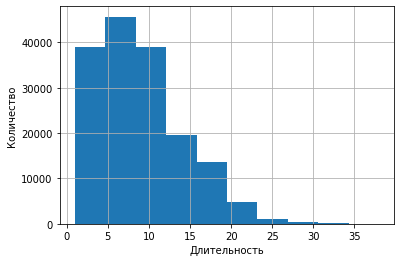

In [31]:
call['duration'].hist()
plt.ylabel('Количество')
plt.xlabel('Длительность')

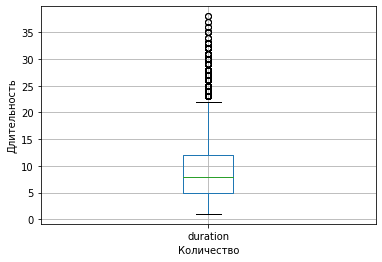

In [32]:
call.boxplot('duration')
plt.xlabel('Количество')
plt.ylabel('Длительность')
plt.show()

Text(0.5, 0, 'Длительность')

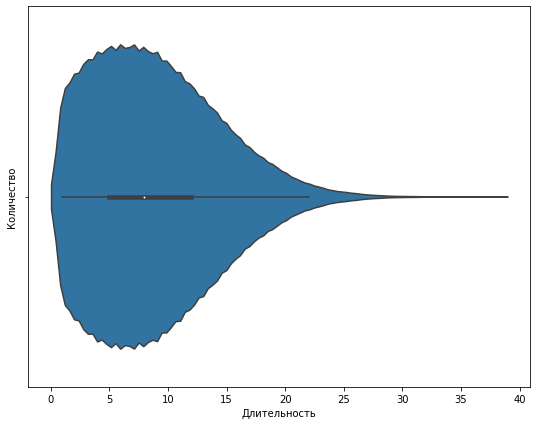

In [33]:
fig, ax = plt.subplots(figsize =(9, 7))

sns.violinplot(ax = ax, x='duration', data=call);
plt.ylabel('Количество')
plt.xlabel('Длительность')

In [34]:
display(inter.head(5))
inter.info()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


приводим даты 'session_date' к формату даты

In [35]:
inter['session_date'] = pd.to_datetime(inter['session_date'])
inter.dtypes

Unnamed: 0               int64
id                      object
mb_used                float64
session_date    datetime64[ns]
user_id                  int64
dtype: object

Unnamed: 0 не нужный столбец не несущий никакой информации удаляем его

In [36]:
inter = inter.drop(columns = ['Unnamed: 0'])
inter.head(5)

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


In [37]:
def _round_inter(row):
    row_round = math.ceil(row)
    return row_round

всесто полной даты указываем месяц

In [38]:
inter['session_date'] = inter['session_date'].dt.month
inter.head()

,id,mb_used,session_date,user_id
0,1000_0,112.95,11,1000
1,1000_1,1052.81,9,1000
2,1000_2,1197.26,6,1000
3,1000_3,550.27,8,1000
4,1000_4,302.56,9,1000


переименуем столбец с датой

In [39]:
inter = inter.rename(columns={"session_date": "month"})
inter.head()

,id,mb_used,month,user_id
0,1000_0,112.95,11,1000
1,1000_1,1052.81,9,1000
2,1000_2,1197.26,6,1000
3,1000_3,550.27,8,1000
4,1000_4,302.56,9,1000


формируем сводную таблицу по юзерам и суммируем потраченный траффик

In [40]:
inter_user = inter.groupby(['user_id', 'month']).agg({'mb_used':'sum'})
display(inter_user)

mb_used
user_id month          
1000    5       2253.49
        6      23233.77
        7      14003.64
        8      14055.93
        9      14568.91
...                 ...
1498    10     20579.36
1499    9       1845.75
        10     17788.51
        11     17963.31
        12     13055.58

[3203 rows x 1 columns]

In [41]:
inter_user['mb_used'] = np.ceil(inter_user['mb_used']/1024).astype(int)
inter_user.head(60)

mb_used
user_id month         
1000    5            3
        6           23
        7           14
        8           14
        9           15
        10          15
        11          15
        12          10
1001    11          18
        12          14
1002    6           11
        7           18
        8           20
        9           17
        10          14
        11          19
        12          18
1003    8            9
        9           13
        10          15
        11          12
        12          10
1004    5           14
        6           18
        7           22
        8           28
        9           15
        10          19
        11          16
        12          18
1005    1            3
        2            8
        3           11
        4           10
        5            8
        6           10
        7            8
        8            8
        9            7
        10           8
        11          13
        12           9
1006    2            2
        3           17
        4           14
        5           13
        6           13
        7           20
        8           19
        9           16
        10          20
        11          13
        12          19
1007    4            8
        5           18
        6           14
        7           16
        8           21
        9           13
        10          15

In [42]:
inter['mb_used'].describe()

count    149396.000000
mean        370.192426
std         278.300951
min           0.000000
25%         138.187500
50%         348.015000
75%         559.552500
max        1724.830000
Name: mb_used, dtype: float64

Text(0.5, 0, 'Обьем трафика')

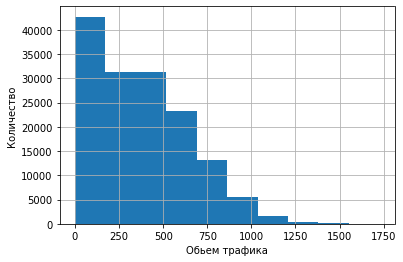

In [43]:
inter['mb_used'].hist()
plt.ylabel('Количество')
plt.xlabel('Обьем трафика')

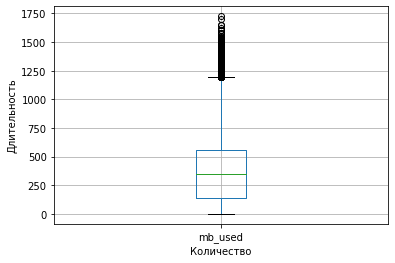

In [44]:
inter.boxplot('mb_used')
plt.xlabel('Количество')
plt.ylabel('Длительность')
plt.show()

Text(0.5, 0, 'Обьем трафика')

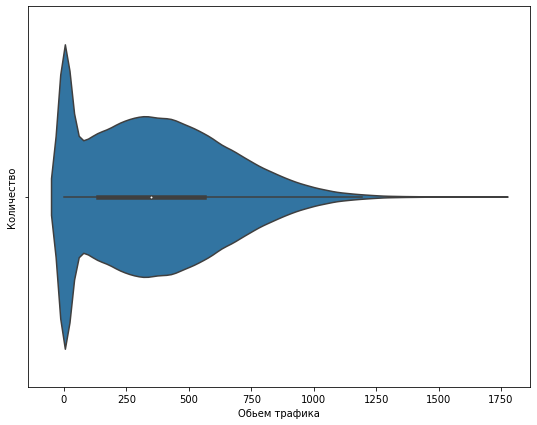

In [45]:
fig, ax = plt.subplots(figsize =(9, 7))
sns.violinplot(ax = ax, x='mb_used', data=inter);
plt.ylabel('Количество')
plt.xlabel('Обьем трафика')

Вычисляем предел усов

In [46]:
q1 = inter['mb_used'].quantile(0.25)
q3 = inter['mb_used'].quantile(0.75)
iqr = q3 - q1
mistash_down = q1 - 1.5 * iqr
mistash_up = q3 + 1.5 * iqr
print('Нижний ус = ', mistash_down)
print('Верхний ус = ', mistash_up)
print('Сколько выше верхнего уса - ', (call['duration'] > mistash_up).sum())
print('Процент значений выше верхнего уса - ', ((inter['mb_used'] > mistash_up).sum()/ inter['mb_used'].count()*100),'%')
print('Процент значений ниже нижнего уса - ', ((inter['mb_used'] > mistash_down).sum()/ inter['mb_used'].count()*100),'%')

Нижний ус =  -493.86
Верхний ус =  1191.6
Сколько выше верхнего уса -  0
Процент значений выше верхнего уса -  0.363463546547431 %
Процент значений ниже нижнего уса -  100.0 %


Количество клиентов с нулевым траффиком
Так как этот траффик никак не тарифицируются и на прибыль компании влияния не оказывают удаляем их как ненужный

In [47]:
display((inter['mb_used'] == 0).sum())
display(inter['mb_used'].count())
print('Процент клиентов с нулевым траффиком-',((inter['mb_used'] == 0).sum()/inter['mb_used'].count())*100, '%' )

19598

149396

Процент клиентов с нулевым траффиком- 13.118155773916303 %


In [48]:
inter = inter[inter['mb_used'] > 0]
display((inter['mb_used'] == 0).sum())
display(inter['mb_used'].count())

0

129798

Text(0.5, 0, 'Обьем трафика')

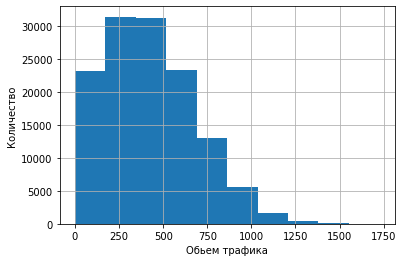

In [49]:
inter['mb_used'].hist()
plt.ylabel('Количество')
plt.xlabel('Обьем трафика')

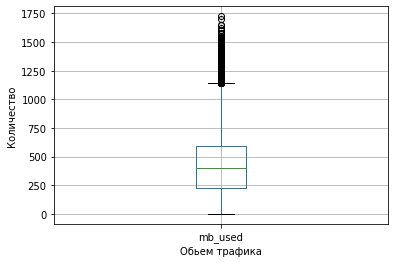

In [50]:
inter.boxplot('mb_used')
plt.ylabel('Количество')
plt.xlabel('Обьем трафика')
plt.show()

Text(0.5, 0, 'Обьем трафика')

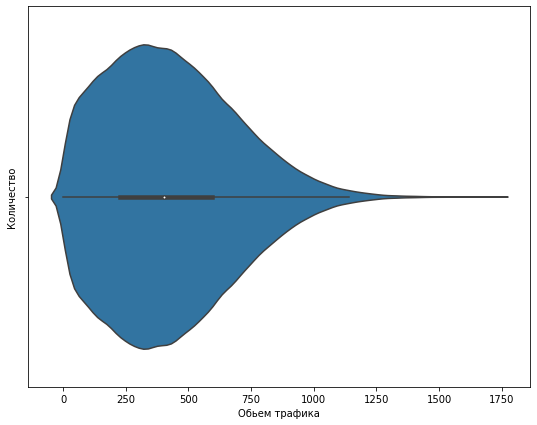

In [51]:
fig, ax = plt.subplots(figsize =(9, 7))
sns.violinplot(ax = ax, x='mb_used', data=inter);
plt.ylabel('Количество')
plt.xlabel('Обьем трафика')

# Таблица mess (информация о сообщениях)

In [52]:
display(mess.head())
mess.info()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


исправляем формат даты и приводим ёе к месяцу

In [53]:
mess['message_date'] = pd.to_datetime(mess['message_date'])
mess.dtypes

id                      object
message_date    datetime64[ns]
user_id                  int64
dtype: object

In [54]:
mess['message_date'] = mess['message_date'].dt.month
mess.head()

,id,message_date,user_id
0,1000_0,6,1000
1,1000_1,10,1000
2,1000_2,8,1000
3,1000_3,6,1000
4,1000_4,12,1000


In [55]:
mess = mess.rename(columns={"message_date": "month"})
mess.head()

,id,month,user_id
0,1000_0,6,1000
1,1000_1,10,1000
2,1000_2,8,1000
3,1000_3,6,1000
4,1000_4,12,1000


# Таблица user (информация о пользователях):

In [56]:
display(user.head())
user.info()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


исправляем формат даты и приводим ёе к месяцу

In [57]:
user['reg_date'] = pd.to_datetime(user['reg_date'])
user['reg_date'] = user['reg_date'].dt.month
#user = user.rename(columns={"reg_date": "month"})
user.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,5,ultra
1,1001,41,NaN,Москва,Иван,Ежов,11,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,6,smart
3,1003,23,NaN,Москва,Белла,Белякова,8,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,5,ultra


# вывод
Исправлен формат даты и заменен на более удобный, удален ненужный столбец, удалены за ненадобностью нулевые значения, определнные выбросы удалены так как занимают ничтожно малый процент, распределения судя по диаграммам соответствуют распределению Пуассона, что нормально

# Посчитаем для каждого пользователя:

- количество сделанных звонков и израсходованных минут разговора по месяцам;
- количество отправленных сообщений по месяцам;
- объем израсходованного интернет-трафика по месяцам;
- помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-- трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).

# Количество сделанных звонков и израсходованных минут разговора по месяцам

делаем сводные таблицы по сумме и их среднему

In [58]:
call_user = call.groupby(['user_id', 'month']).agg({'duration':['sum', 'mean']})
call_user.columns = ['call_sum', 'call_mean']
display(call_user)

call_sum  call_mean
user_id month                     
1000    5           159   9.352941
        6           172   6.142857
        7           340   8.292683
        8           408   9.714286
        9           466  10.130435
...                 ...        ...
1498    10          247   8.233333
1499    9            70   8.750000
        10          449  10.204545
        11          612   9.870968
        12          492   8.785714

[3168 rows x 2 columns]

# Kоличество отправленных сообщений по месяцам

In [59]:
display(mess.head())

,id,month,user_id
0,1000_0,6,1000
1,1000_1,10,1000
2,1000_2,8,1000
3,1000_3,6,1000
4,1000_4,12,1000


In [60]:
mess_user = mess.groupby(['user_id', 'month']).agg({'user_id':'count'})
mess_user.columns = ['mess_sum']
display(mess_user)

mess_sum
user_id month          
1000    5            22
        6            60
        7            75
        8            81
        9            57
...                 ...
1498    10           42
1499    9            11
        10           48
        11           59
        12           66

[2717 rows x 1 columns]

In [61]:
mess_user.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2717 entries, (1000, 5) to (1499, 12)
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   mess_sum  2717 non-null   int64
dtypes: int64(1)
memory usage: 32.7 KB


# Объем израсходованного интернет-трафика по месяцам

In [62]:
inter.head()
inter_user = inter.groupby(['user_id', 'month']).agg({'mb_used':['sum', 'mean']})
inter_user.columns = ['inter_sum', 'inter_mean']

In [63]:
display(inter_user)

inter_sum  inter_mean
user_id month                       
1000    5        2253.49  563.372500
        6       23233.77  528.040227
        7       14003.64  500.130000
        8       14055.93  520.590000
        9       14568.91  582.756400
...                  ...         ...
1498    10      20579.36  419.986939
1499    9        1845.75  461.437500
        10      17788.51  413.686279
        11      17963.31  460.597692
        12      13055.58  326.389500

[3201 rows x 2 columns]

# Тариф и город пользователя user

In [64]:
user.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,5,ultra
1,1001,41,NaN,Москва,Иван,Ежов,11,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,6,smart
3,1003,23,NaN,Москва,Белла,Белякова,8,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,5,ultra


In [65]:
user_tarif_city = user.loc[:,['user_id', 'city', 'tariff' ]]
display(user_tarif_city.head())

,user_id,city,tariff
0,1000,Краснодар,ultra
1,1001,Москва,smart
2,1002,Стерлитамак,smart
3,1003,Москва,ultra
4,1004,Новокузнецк,ultra


In [66]:
df = call_user.join(inter_user, on=['user_id', 'month'], how='outer')
display(df)

call_sum  call_mean  inter_sum  inter_mean
user_id month                                            
1000    5         159.0   9.352941    2253.49  563.372500
        6         172.0   6.142857   23233.77  528.040227
        7         340.0   8.292683   14003.64  500.130000
        8         408.0   9.714286   14055.93  520.590000
        9         466.0  10.130435   14568.91  582.756400
...                 ...        ...        ...         ...
1489    8           NaN        NaN   11050.56  394.662857
        9           NaN        NaN   17206.30  351.148980
        10          NaN        NaN   19559.44  376.143077
        11          NaN        NaN   17491.56  388.701333
        12          NaN        NaN   17322.51  402.849070

[3214 rows x 4 columns]

In [67]:
df = df.merge(mess_user, on=['user_id', 'month'], how='outer')
display(df)

call_sum  call_mean  inter_sum  inter_mean  mess_sum
user_id month                                                      
1000    5         159.0   9.352941    2253.49  563.372500      22.0
        6         172.0   6.142857   23233.77  528.040227      60.0
        7         340.0   8.292683   14003.64  500.130000      75.0
        8         408.0   9.714286   14055.93  520.590000      81.0
        9         466.0  10.130435   14568.91  582.756400      57.0
...                 ...        ...        ...         ...       ...
1489    8           NaN        NaN   11050.56  394.662857      17.0
        9           NaN        NaN   17206.30  351.148980      32.0
        10          NaN        NaN   19559.44  376.143077      21.0
        11          NaN        NaN   17491.56  388.701333      20.0
        12          NaN        NaN   17322.51  402.849070      35.0

[3214 rows x 5 columns]

In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3214 entries, (1000, 5) to (1489, 12)
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   call_sum    3168 non-null   float64
 1   call_mean   3168 non-null   float64
 2   inter_sum   3201 non-null   float64
 3   inter_mean  3201 non-null   float64
 4   mess_sum    2717 non-null   float64
dtypes: float64(5)
memory usage: 155.5 KB


Обнаружили пропуски в данных по смс

In [69]:
df['mess_sum'].isna().sum()

497

In [70]:
df['inter_sum'].isna().sum()

13

In [71]:
df['inter_mean'].isna().sum()

13

In [72]:
df['mess_sum'].describe()

count    2717.000000
mean       45.283769
std        35.051363
min         1.000000
25%        19.000000
50%        38.000000
75%        63.000000
max       224.000000
Name: mess_sum, dtype: float64

Думаю это люди которые не отправляют смс вообще поэтому меняем значения на ноль и так как 13 значений ни на что не влияют 'inter_mean', 'mess_sum' их тоже

In [73]:
df['mess_sum'].fillna(0, inplace=True)
df['inter_mean'].fillna(0, inplace=True)
df['inter_sum'].fillna(0, inplace=True)

In [74]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3214 entries, (1000, 5) to (1489, 12)
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   call_sum    3168 non-null   float64
 1   call_mean   3168 non-null   float64
 2   inter_sum   3214 non-null   float64
 3   inter_mean  3214 non-null   float64
 4   mess_sum    3214 non-null   float64
dtypes: float64(5)
memory usage: 155.5 KB


In [75]:
display(df.head(3) )
display(user_tarif_city.head(50))

call_sum  call_mean  inter_sum  inter_mean  mess_sum
user_id month                                                      
1000    5         159.0   9.352941    2253.49  563.372500      22.0
        6         172.0   6.142857   23233.77  528.040227      60.0
        7         340.0   8.292683   14003.64  500.130000      75.0

,user_id,city,tariff
0,1000,Краснодар,ultra
1,1001,Москва,smart
2,1002,Стерлитамак,smart
3,1003,Москва,ultra
4,1004,Новокузнецк,ultra
5,1005,Набережные Челны,smart
6,1006,Ульяновск,smart
7,1007,Москва,smart
8,1008,Челябинск,smart
9,1009,Пермь,smart


In [76]:
df.fillna(0)

call_sum  call_mean  inter_sum  inter_mean  mess_sum
user_id month                                                      
1000    5         159.0   9.352941    2253.49  563.372500      22.0
        6         172.0   6.142857   23233.77  528.040227      60.0
        7         340.0   8.292683   14003.64  500.130000      75.0
        8         408.0   9.714286   14055.93  520.590000      81.0
        9         466.0  10.130435   14568.91  582.756400      57.0
...                 ...        ...        ...         ...       ...
1489    8           0.0   0.000000   11050.56  394.662857      17.0
        9           0.0   0.000000   17206.30  351.148980      32.0
        10          0.0   0.000000   19559.44  376.143077      21.0
        11          0.0   0.000000   17491.56  388.701333      20.0
        12          0.0   0.000000   17322.51  402.849070      35.0

[3214 rows x 5 columns]

In [77]:
user_tarif_city.fillna(0)

,user_id,city,tariff
0,1000,Краснодар,ultra
1,1001,Москва,smart
2,1002,Стерлитамак,smart
3,1003,Москва,ultra
4,1004,Новокузнецк,ultra
5,1005,Набережные Челны,smart
6,1006,Ульяновск,smart
7,1007,Москва,smart
8,1008,Челябинск,smart
9,1009,Пермь,smart


In [78]:
df_total = df.reset_index().merge(user_tarif_city, on=['user_id'], how='outer')
df_total=df_total.fillna(0)
display(df_total)

,user_id,month,call_sum,call_mean,inter_sum,inter_mean,mess_sum,city,tariff
0,1000,5.0,159.0,9.352941,2253.49,563.372500,22.0,Краснодар,ultra
1,1000,6.0,172.0,6.142857,23233.77,528.040227,60.0,Краснодар,ultra
2,1000,7.0,340.0,8.292683,14003.64,500.130000,75.0,Краснодар,ultra
3,1000,8.0,408.0,9.714286,14055.93,520.590000,81.0,Краснодар,ultra
4,1000,9.0,466.0,10.130435,14568.91,582.756400,57.0,Краснодар,ultra
...,...,...,...,...,...,...,...,...,...
3211,1489,10.0,0.0,0.000000,19559.44,376.143077,21.0,Санкт-Петербург,smart
3212,1489,11.0,0.0,0.000000,17491.56,388.701333,20.0,Санкт-Петербург,smart
3213,1489,12.0,0.0,0.000000,17322.51,402.849070,35.0,Санкт-Петербург,smart
3214,1128,0.0,0.0,0.000000,0.00,0.000000,0.0,Волжский,ultra


In [79]:
df_total = df_total.astype({"month": "Int64"})
df_total = df_total.astype({"mess_sum": "Int64"})
df_total = df_total.astype({"call_sum": "Int64"})


display(df_total)

,user_id,month,call_sum,call_mean,inter_sum,inter_mean,mess_sum,city,tariff
0,1000,5,159,9.352941,2253.49,563.372500,22,Краснодар,ultra
1,1000,6,172,6.142857,23233.77,528.040227,60,Краснодар,ultra
2,1000,7,340,8.292683,14003.64,500.130000,75,Краснодар,ultra
3,1000,8,408,9.714286,14055.93,520.590000,81,Краснодар,ultra
4,1000,9,466,10.130435,14568.91,582.756400,57,Краснодар,ultra
...,...,...,...,...,...,...,...,...,...
3211,1489,10,0,0.000000,19559.44,376.143077,21,Санкт-Петербург,smart
3212,1489,11,0,0.000000,17491.56,388.701333,20,Санкт-Петербург,smart
3213,1489,12,0,0.000000,17322.51,402.849070,35,Санкт-Петербург,smart
3214,1128,0,0,0.000000,0.00,0.000000,0,Волжский,ultra


In [80]:
# проверка
df_chek = df_total.reset_index()

In [81]:
# проверка
len(df_chek.user_id.unique())


500

In [82]:
display(tarif.head())

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [83]:
tarif = tarif.rename(columns={"tariff_name": "tariff"})
display(tarif.head())

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [84]:
df_total = df_total.reset_index().merge(tarif, on=['tariff'], how='left')
display(df_total.head())

,index,user_id,month,call_sum,call_mean,inter_sum,inter_mean,mess_sum,city,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,0,1000,5,159,9.352941,2253.49,563.372500,22,Краснодар,ultra,1000,30720,3000,1950,150,1,1
1,1,1000,6,172,6.142857,23233.77,528.040227,60,Краснодар,ultra,1000,30720,3000,1950,150,1,1
2,2,1000,7,340,8.292683,14003.64,500.130000,75,Краснодар,ultra,1000,30720,3000,1950,150,1,1
3,3,1000,8,408,9.714286,14055.93,520.590000,81,Краснодар,ultra,1000,30720,3000,1950,150,1,1
4,4,1000,9,466,10.130435,14568.91,582.756400,57,Краснодар,ultra,1000,30720,3000,1950,150,1,1


In [85]:
df_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   index                  3216 non-null   int64  
 1   user_id                3216 non-null   int64  
 2   month                  3216 non-null   Int64  
 3   call_sum               3216 non-null   Int64  
 4   call_mean              3216 non-null   float64
 5   inter_sum              3216 non-null   float64
 6   inter_mean             3216 non-null   float64
 7   mess_sum               3216 non-null   Int64  
 8   city                   3216 non-null   object 
 9   tariff                 3216 non-null   object 
 10  messages_included      3216 non-null   int64  
 11  mb_per_month_included  3216 non-null   int64  
 12  minutes_included       3216 non-null   int64  
 13  rub_monthly_fee        3216 non-null   int64  
 14  rub_per_gb             3216 non-null   int64  
 15  rub_

Стоимость rub_per_gb за Гигабайт переведем за мегабайт

In [86]:
df_total = df_total.rename(columns={'rub_per_gb': 'rub_per_mb'})
display(df_total.head())

,index,user_id,month,call_sum,call_mean,inter_sum,inter_mean,mess_sum,city,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_mb,rub_per_message,rub_per_minute
0,0,1000,5,159,9.352941,2253.49,563.372500,22,Краснодар,ultra,1000,30720,3000,1950,150,1,1
1,1,1000,6,172,6.142857,23233.77,528.040227,60,Краснодар,ultra,1000,30720,3000,1950,150,1,1
2,2,1000,7,340,8.292683,14003.64,500.130000,75,Краснодар,ultra,1000,30720,3000,1950,150,1,1
3,3,1000,8,408,9.714286,14055.93,520.590000,81,Краснодар,ultra,1000,30720,3000,1950,150,1,1
4,4,1000,9,466,10.130435,14568.91,582.756400,57,Краснодар,ultra,1000,30720,3000,1950,150,1,1


In [87]:
df_total['inter_sum'].fillna(0, inplace=True)

округляем inter_sum до большего

# Посчитаем помесячную выручку с каждого пользователя (вычтем бесплатный лимит из суммарного количества звонков, сообщений и интернет-- - трафика; остаток умножим на значение из тарифного плана; прибавим абонентскую плату, соответствующую тарифному плану).

посчитаем сколько пользователь в месяц отдает за разговоры

In [88]:
df_total['minutes_paid'] = (df_total['call_sum'] - df_total['minutes_included']) * df_total['rub_per_minute']
df_total.loc[df_total['minutes_paid'] < 0, 'minutes_paid'] = 0
display(df_total.head())

,index,user_id,month,call_sum,call_mean,inter_sum,inter_mean,mess_sum,city,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_mb,rub_per_message,rub_per_minute,minutes_paid
0,0,1000,5,159,9.352941,2253.49,563.372500,22,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0
1,1,1000,6,172,6.142857,23233.77,528.040227,60,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0
2,2,1000,7,340,8.292683,14003.64,500.130000,75,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0
3,3,1000,8,408,9.714286,14055.93,520.590000,81,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0
4,4,1000,9,466,10.130435,14568.91,582.756400,57,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0


Меняем в столбце df_total['minutes_paid'] отрицательные значения на нулевые

посчитаем сколько пользователь в месяц отдает за интернет добавим столбец df_total['internet_paid']

In [89]:
df_total['internet_paid'] = (df_total['inter_sum'] - df_total['mb_per_month_included'])/1024
df_total['internet_paid'] = np.ceil(df_total['internet_paid'])
df_total['internet_paid'] = df_total['internet_paid'] * df_total['rub_per_mb']
df_total.loc[df_total['internet_paid'] < 0, 'internet_paid'] = 0
display(df_total.head(50))

,index,user_id,month,call_sum,call_mean,inter_sum,inter_mean,mess_sum,city,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_mb,rub_per_message,rub_per_minute,minutes_paid,internet_paid
0,0,1000,5,159,9.352941,2253.49,563.372500,22,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0,0.0
1,1,1000,6,172,6.142857,23233.77,528.040227,60,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0,0.0
2,2,1000,7,340,8.292683,14003.64,500.130000,75,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0,0.0
3,3,1000,8,408,9.714286,14055.93,520.590000,81,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0,0.0
4,4,1000,9,466,10.130435,14568.91,582.756400,57,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0,0.0
5,5,1000,10,350,7.954545,14702.49,544.536667,73,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0,0.0
6,6,1000,11,338,9.135135,14756.47,641.585652,58,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0,0.0
7,7,1000,12,333,8.763158,9817.61,516.716316,70,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0,0.0
8,8,1001,11,430,9.555556,18429.34,392.113617,0,Москва,smart,50,15360,500,550,200,3,3,0,600.0
9,9,1001,12,414,8.808511,14036.66,401.047429,0,Москва,smart,50,15360,500,550,200,3,3,0,0.0


In [90]:
df_total['internet_paid'].sum()

1450750.0

In [91]:
df_total[df_total['internet_paid'] > 0]

,index,user_id,month,call_sum,call_mean,inter_sum,inter_mean,mess_sum,city,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_mb,rub_per_message,rub_per_minute,minutes_paid,internet_paid
8,8,1001,11,430,9.555556,18429.34,392.113617,0,Москва,smart,50,15360,500,550,200,3,3,0,600.0
11,11,1002,7,214,10.190476,17580.10,399.547727,11,Стерлитамак,smart,50,15360,500,550,200,3,3,0,600.0
12,12,1002,8,289,7.810811,20319.26,406.385200,13,Стерлитамак,smart,50,15360,500,550,200,3,3,0,1000.0
13,13,1002,9,206,8.240000,16691.08,379.342727,4,Стерлитамак,smart,50,15360,500,550,200,3,3,0,400.0
15,15,1002,11,243,9.720000,18587.28,422.438182,16,Стерлитамак,smart,50,15360,500,550,200,3,3,0,800.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3203,3203,1328,12,0,0.000000,39419.73,474.936506,7,Мурманск,ultra,1000,30720,3000,1950,150,1,1,0,1350.0
3210,3210,1489,9,0,0.000000,17206.30,351.148980,32,Санкт-Петербург,smart,50,15360,500,550,200,3,3,0,400.0
3211,3211,1489,10,0,0.000000,19559.44,376.143077,21,Санкт-Петербург,smart,50,15360,500,550,200,3,3,0,1000.0
3212,3212,1489,11,0,0.000000,17491.56,388.701333,20,Санкт-Петербург,smart,50,15360,500,550,200,3,3,0,600.0


посчитаем сколько пользователь в месяц отдает за SMS

In [92]:
df_total['message_paid'] = (df_total['mess_sum'] - df_total['messages_included']) * df_total['rub_per_message']
df_total.loc[df_total['message_paid'] < 0, 'message_paid'] = 0
display(df_total.head())

,index,user_id,month,call_sum,call_mean,inter_sum,inter_mean,mess_sum,city,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_mb,rub_per_message,rub_per_minute,minutes_paid,internet_paid,message_paid
0,0,1000,5,159,9.352941,2253.49,563.372500,22,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0,0.0,0
1,1,1000,6,172,6.142857,23233.77,528.040227,60,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0,0.0,0
2,2,1000,7,340,8.292683,14003.64,500.130000,75,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0,0.0,0
3,3,1000,8,408,9.714286,14055.93,520.590000,81,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0,0.0,0
4,4,1000,9,466,10.130435,14568.91,582.756400,57,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0,0.0,0


включим столбец с суммой выручек

In [93]:
df_total['total_bill'] = df_total['minutes_paid'] + df_total['internet_paid'] + df_total['message_paid'] + df_total['rub_monthly_fee']
display(df_total.head())

,index,user_id,month,call_sum,call_mean,inter_sum,inter_mean,mess_sum,city,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_mb,rub_per_message,rub_per_minute,minutes_paid,internet_paid,message_paid,total_bill
0,0,1000,5,159,9.352941,2253.49,563.372500,22,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0,0.0,0,1950.0
1,1,1000,6,172,6.142857,23233.77,528.040227,60,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0,0.0,0,1950.0
2,2,1000,7,340,8.292683,14003.64,500.130000,75,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0,0.0,0,1950.0
3,3,1000,8,408,9.714286,14055.93,520.590000,81,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0,0.0,0,1950.0
4,4,1000,9,466,10.130435,14568.91,582.756400,57,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0,0.0,0,1950.0


<div class="alert alert-info">
<b>Комментарий студента:</b>
<br> исправлено
</div>

# Блок проверки кода

In [94]:
((inter['mb_used'].sum().round() - df_total.inter_sum.sum().round())/1024).round()
# потеряно Гб.

0.0

In [95]:
df_total['total_bill'].sum()

4916951.0

In [96]:
df_total['minutes_paid'].sum(), df_total['internet_paid'].sum(), df_total['message_paid'].sum(), df_total['rub_monthly_fee'].sum()

(278217, 1450750.0, 38784, 3149200)

# 3. Рассмотрим поведение клиентов оператора, исходя из выборки.

# 3.1 Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц?

Сколько минут разговора требуется пользователям каждого тарифа в месяц

In [97]:
display(df_total.head())
# display(df_total_call_month_sum.head())

,index,user_id,month,call_sum,call_mean,inter_sum,inter_mean,mess_sum,city,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_mb,rub_per_message,rub_per_minute,minutes_paid,internet_paid,message_paid,total_bill
0,0,1000,5,159,9.352941,2253.49,563.372500,22,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0,0.0,0,1950.0
1,1,1000,6,172,6.142857,23233.77,528.040227,60,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0,0.0,0,1950.0
2,2,1000,7,340,8.292683,14003.64,500.130000,75,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0,0.0,0,1950.0
3,3,1000,8,408,9.714286,14055.93,520.590000,81,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0,0.0,0,1950.0
4,4,1000,9,466,10.130435,14568.91,582.756400,57,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0,0.0,0,1950.0


Строим двойную диаграмму по сумме звонков длительности

In [1]:
smart_call_sum = df_total_call_month_sum.query("tariff == 'smart'")
ultra_call_sum = df_total_call_month_sum.query("tariff == 'ultra'")

#y_month_sum = list(smart_call_sum.index.get_level_values(0))

smart_call_sum['call_sum'].plot(kind='hist', alpha=1, grid=True)
ultra_call_sum['call_sum'].plot(kind='hist', alpha=0.7, grid=True)
plt.xlabel('Количество')
plt.ylabel('Длительность')
plt.title('Строим двойную диаграмму по сумме звонков длительности')
plt.show()


NameError: name 'df_total_call_month_sum' is not defined

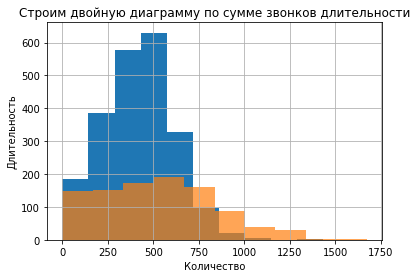

In [98]:
smart_call_sum = df_total.query("tariff == 'smart'")
ultra_call_sum = df_total.query("tariff == 'ultra'")

smart_call_sum['call_sum'].plot(kind='hist', alpha=1, grid=True)
ultra_call_sum['call_sum'].plot(kind='hist', alpha=0.7, grid=True)
plt.xlabel('Количество')
plt.ylabel('Длительность')
plt.title('Строим двойную диаграмму по сумме звонков длительности')
plt.show()

Строим двойную диаграмму по среднему арифметическому количества звонков

Чтобы обращаться к месяцу как к обычному столбцу сделать в фрейме reset_index.

In [100]:
display(smart_call_mean.head())
display(smart_call_mean.reset_index().head())

call_mean
user_id month tariff           
1001    11    smart    9.555556
        12    smart    8.808511
1002    6     smart    8.357143
        7     smart   10.190476
        8     smart    7.810811

,user_id,month,tariff,call_mean
0,1001,11,smart,9.555556
1,1001,12,smart,8.808511
2,1002,6,smart,8.357143
3,1002,7,smart,10.190476
4,1002,8,smart,7.810811


In [101]:
display(smart_call_mean.head())
#display(df_total_call_month_sum.head())
display(df_total_call_month_mean.head())

call_mean
user_id month tariff           
1001    11    smart    9.555556
        12    smart    8.808511
1002    6     smart    8.357143
        7     smart   10.190476
        8     smart    7.810811

call_mean
user_id month tariff           
1000    5     ultra    9.352941
        6     ultra    6.142857
        7     ultra    8.292683
        8     ultra    9.714286
        9     ultra   10.130435

In [102]:
smart_call_sum['call_sum'].describe()

count    2230.000000
mean      417.747534
std       190.476754
min         0.000000
25%       282.000000
50%       421.500000
75%       545.000000
max      1435.000000
Name: call_sum, dtype: float64

In [103]:
ultra_call_sum['call_sum'].describe()

count     986.000000
mean      526.089249
std       317.887549
min         0.000000
25%       282.500000
50%       518.000000
75%       751.750000
max      1673.000000
Name: call_sum, dtype: float64

Доступ к сводной таблице по индексу

display(df_total_call_month_sum.index.get_level_values(0))

# сколько сообщений

Строим двойную диаграмму по сумме смс

In [104]:
df_total_mess_month_sum = df_total.groupby(['user_id', 'month','tariff']).agg({'mess_sum':'sum'})
display(df_total_mess_month_sum.head())

mess_sum
user_id month tariff          
1000    5     ultra         22
        6     ultra         60
        7     ultra         75
        8     ultra         81
        9     ultra         57

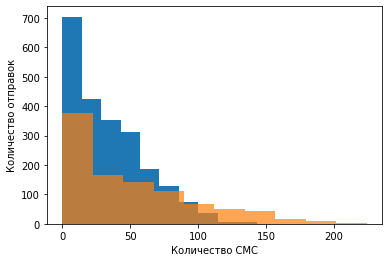

In [105]:
smart_mess = df_total_mess_month_sum.query("tariff == 'smart'")
ultra_mess = df_total_mess_month_sum.query("tariff == 'ultra'")

smart_mess['mess_sum'].plot(kind='hist', alpha=1)
ultra_mess['mess_sum'].plot(kind='hist', alpha=0.7)
plt.xlabel('Количество СМС')
plt.ylabel('Количество отправок')
plt.show()

# какой объём интернет-трафика

In [106]:
df_total_inter_month_sum = df_total.groupby(['user_id','month','tariff']).agg({'inter_sum':'sum'})
display(df_total_inter_month_sum.head())

inter_sum
user_id month tariff           
1000    5     ultra     2253.49
        6     ultra    23233.77
        7     ultra    14003.64
        8     ultra    14055.93
        9     ultra    14568.91

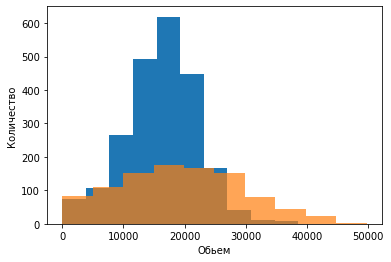

In [107]:
smart_inter = df_total_inter_month_sum.query("tariff == 'smart'")
ultra_inter = df_total_inter_month_sum.query("tariff == 'ultra'")

smart_inter['inter_sum'].plot(kind='hist', alpha=1)
ultra_inter['inter_sum'].plot(kind='hist', alpha=0.7)
plt.xlabel('Обьем')
plt.ylabel('Количество')
plt.show()

In [108]:
display(df_total.head())

,index,user_id,month,call_sum,call_mean,inter_sum,inter_mean,mess_sum,city,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_mb,rub_per_message,rub_per_minute,minutes_paid,internet_paid,message_paid,total_bill
0,0,1000,5,159,9.352941,2253.49,563.372500,22,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0,0.0,0,1950.0
1,1,1000,6,172,6.142857,23233.77,528.040227,60,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0,0.0,0,1950.0
2,2,1000,7,340,8.292683,14003.64,500.130000,75,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0,0.0,0,1950.0
3,3,1000,8,408,9.714286,14055.93,520.590000,81,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0,0.0,0,1950.0
4,4,1000,9,466,10.130435,14568.91,582.756400,57,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0,0.0,0,1950.0


In [109]:
df_total_inter_month_mean = df_total[['user_id','month','tariff','inter_mean']]
smart_inter_mean = df_total_inter_month_mean.query("tariff == 'smart'")
ultra_inter_mean = df_total_inter_month_mean.query("tariff == 'ultra'")

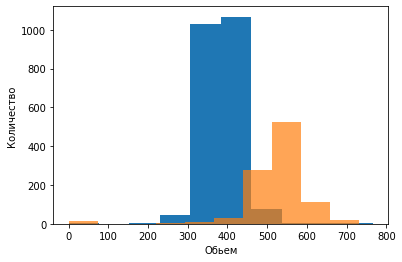

In [110]:
smart_inter_mean['inter_mean'].plot(kind='hist', alpha=1)
ultra_inter_mean['inter_mean'].plot(kind='hist', alpha=0.7)
plt.xlabel('Обьем')
plt.ylabel('Количество')
plt.show()

# 3.2 Посчитаем среднее количество, дисперсию и стандартное отклонение.

In [111]:
total_var_std = df_total.groupby(['tariff']).agg({'call_sum':['mean','median','var', 'std'], 'mess_sum':['mean','median','var', 'std'], 'inter_sum':['mean','median','var', 'std']})
total_var_std_ind = total_var_std.reset_index()
display(total_var_std_ind)

tariff    call_sum                                     mess_sum                                    inter_sum                                       
                mean median            var         std       mean median          var        std          mean     median           var           std
0  smart  417.747534  421.5   36281.393836  190.476754  33.369058   28.0   796.955256  28.230396  16201.118655  16505.475  3.456484e+07   5879.187315
1  ultra  526.089249  518.0  101052.493549  317.887549  49.313387   38.0  2285.417425  47.806040  19449.059970  19304.020  1.020321e+08  10101.095459

In [112]:
df_total['call_sum'].describe()

count    3216.000000
mean      450.964241
std       242.096312
min         0.000000
25%       282.000000
50%       443.000000
75%       589.000000
max      1673.000000
Name: call_sum, dtype: float64

# Постройте гистограммы. Опишите распределения.
Строим двойную диаграмму по сумме звонков длительности

,index,user_id,month,call_sum,call_mean,inter_sum,inter_mean,mess_sum,city,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_mb,rub_per_message,rub_per_minute,minutes_paid,internet_paid,message_paid,total_bill
8,8,1001,11,430,9.555556,18429.34,392.113617,0,Москва,smart,50,15360,500,550,200,3,3,0,600.0,0,1150.0
9,9,1001,12,414,8.808511,14036.66,401.047429,0,Москва,smart,50,15360,500,550,200,3,3,0,0.0,0,550.0
10,10,1002,6,117,8.357143,10856.82,402.104444,4,Стерлитамак,smart,50,15360,500,550,200,3,3,0,0.0,0,550.0
11,11,1002,7,214,10.190476,17580.10,399.547727,11,Стерлитамак,smart,50,15360,500,550,200,3,3,0,600.0,0,1150.0
12,12,1002,8,289,7.810811,20319.26,406.385200,13,Стерлитамак,smart,50,15360,500,550,200,3,3,0,1000.0,0,1550.0


count    2230.000000
mean      417.747534
std       190.476754
min         0.000000
25%       282.000000
50%       421.500000
75%       545.000000
max      1435.000000
Name: call_sum, dtype: float64

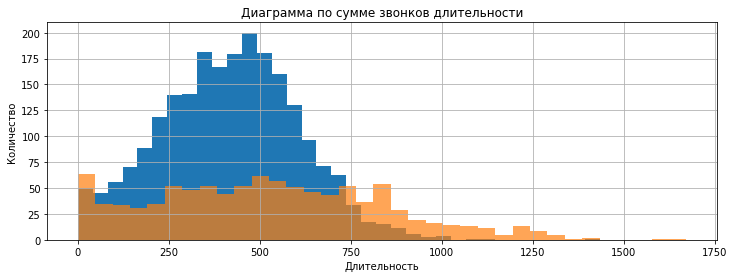

In [113]:
display(smart_call_sum.head())
display(smart_call_sum['call_sum'].describe())
smart_call_sum['call_sum'].plot(kind='hist', alpha=1,  grid=True, figsize=(12, 4), bins=35 )
ultra_call_sum['call_sum'].plot(kind='hist', alpha=0.7, grid=True, figsize=(12, 4), bins=35  )
plt.xlabel('Длительность')
plt.ylabel('Количество')
plt.title('Диаграмма по сумме звонков длительности')
plt.show()

count      986.000000
mean     19449.059970
std      10101.095459
min          0.000000
25%      11748.585000
50%      19304.020000
75%      26835.885000
max      49745.690000
Name: inter_sum, dtype: float64

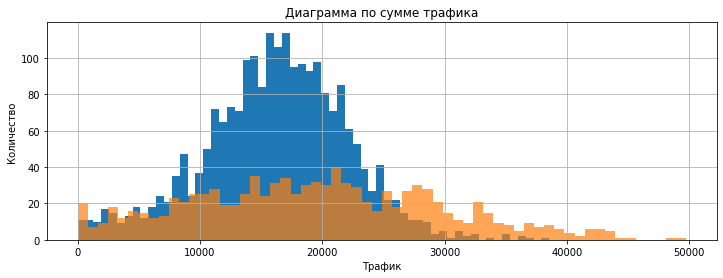

In [114]:
display(ultra_inter['inter_sum'].describe())
df_total_inter_month_sum = df_total.groupby(['user_id','month','tariff']).agg({'inter_sum':'sum'})
smart_inter['inter_sum'].plot(kind='hist', alpha=1, grid=True, figsize=(12, 4), bins=60 )
ultra_inter['inter_sum'].plot(kind='hist', alpha=0.7, grid=True, figsize=(12, 4), bins=60 )
plt.ylabel('Количество')
plt.xlabel('Трафик')
plt.title('Диаграмма по сумме трафика')
plt.show()

count    2230.000000
mean       33.369058
std        28.230396
min         0.000000
25%        10.000000
50%        28.000000
75%        51.000000
max       143.000000
Name: mess_sum, dtype: float64

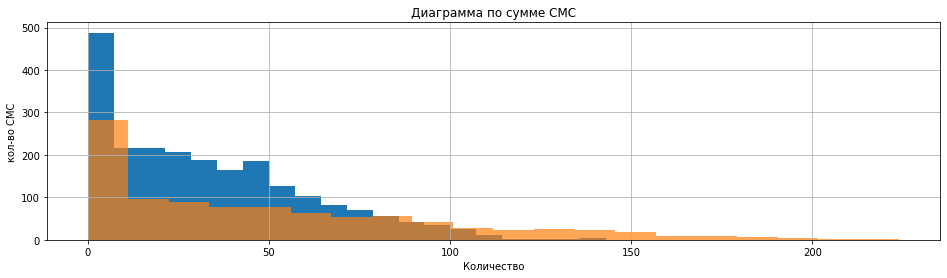

In [115]:
display(smart_mess['mess_sum'].describe())
smart_mess['mess_sum'].plot(kind='hist', alpha=1, grid=True,  figsize=(12, 4), bins=20 )
ultra_mess['mess_sum'].plot(kind='hist', alpha=0.7, grid=True,  figsize=(16, 4), bins=20 )
plt.xlabel('Количество')
plt.ylabel('кол-во СМС')
plt.title('Диаграмма по сумме СМС')
plt.show()

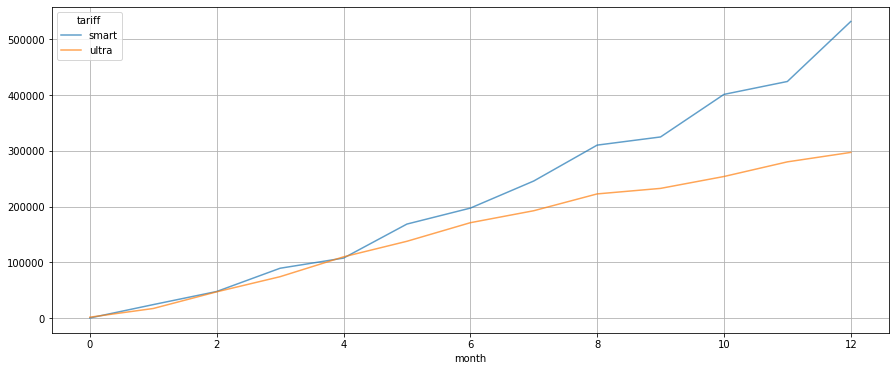

tariff,smart,ultra
month,,
0,550.0,1950.0
1,24525.0,17550.0
2,48001.0,47400.0
3,89676.0,74550.0
4,107866.0,110100.0
5,168849.0,138000.0
6,197459.0,171300.0
7,246014.0,192750.0
8,310340.0,222900.0


In [116]:
df_total.pivot_table(index='month', values='total_bill', columns='tariff', aggfunc=sum).plot(alpha=0.7, grid=True, figsize=(15, 6))
plt.show()
dinamic_total_bill=df_total.pivot_table(index='month', values='total_bill', columns='tariff', aggfunc=sum)
display(dinamic_total_bill.head(12))

Динамика подключивщихся пользователей по месяцам

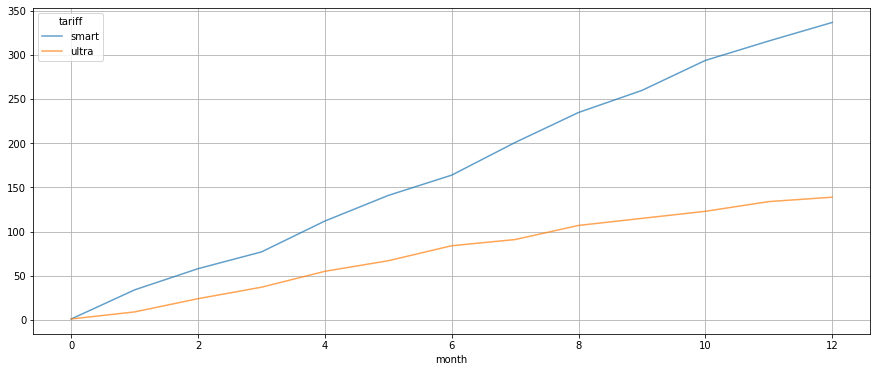

In [117]:
df_total.pivot_table(index='month', values='user_id', columns='tariff', aggfunc='count').plot(alpha=0.7, grid=True, figsize=(15, 6))
plt.show()

In [118]:
dinamic_user_id = df_total.pivot_table(index='month', values='user_id', columns='tariff', aggfunc='count')
display(dinamic_user_id.head() )

tariff,smart,ultra
month,,
0,1,1
1,34,9
2,58,24
3,77,37
4,112,55


Считаем доход с кажного клиента помесячно для каждого из тарифоф

In [119]:
dinamic_total = dinamic_total_bill.reset_index().merge(dinamic_user_id, on=['month'], how='left')
"""склеиваем таблицы с общей выручкой по месяцам с количеством подключившихся пользователей""" 
"""Делим общую выручку на количество пользователей помесячно узнаем сколько в месяц принес один пользователь с разных тарифов"""
dinamic_total['profit_smart_user'] = dinamic_total['smart_x']/dinamic_total['smart_y']
dinamic_total['profit_ultra_user'] = dinamic_total['ultra_x']/dinamic_total['ultra_y']
dinamic_total = dinamic_total.rename(columns={'smart_x':'profit_smart_month','ultra_x':'profit_ultra_month','smart_y':'sum_user_smart', 'ultra_y': 'sum_user_ultra'})
display(dinamic_total.head(10))

tariff,month,profit_smart_month,profit_ultra_month,sum_user_smart,sum_user_ultra,profit_smart_user,profit_ultra_user
0,0,550.0,1950.0,1,1,550.0,1950.0
1,1,24525.0,17550.0,34,9,721.323529,1950.0
2,2,48001.0,47400.0,58,24,827.603448,1975.0
3,3,89676.0,74550.0,77,37,1164.623377,2014.864865
4,4,107866.0,110100.0,112,55,963.089286,2001.818182
5,5,168849.0,138000.0,141,67,1197.510638,2059.701493
6,6,197459.0,171300.0,164,84,1204.018293,2039.285714
7,7,246014.0,192750.0,201,91,1223.950249,2118.131868
8,8,310340.0,222900.0,235,107,1320.595745,2083.17757
9,9,324986.0,232800.0,260,115,1249.946154,2024.347826


Суммируем выручку с тарифа и абонента

In [120]:
print('Выручка за год с тарифа Смарт -  {:.0f} руб. '.format(dinamic_total['profit_smart_month'].sum()))
print('Выручка за год с тарифа Ультра - {:.0f} руб. '.format(dinamic_total['profit_ultra_month'].sum()))
print('________________________________________________________________')
print()
print('Средняя выручка за год с тарифа Смарт -  {:.0f} руб. '.format(dinamic_total['profit_smart_month'].mean()))
print('Средняя выручка за год с тарифа Ультра - {:.0f} руб. '.format(dinamic_total['profit_ultra_month'].mean()))
print('________________________________________________________________')
print()
print('Выручка за год с одного абонента тарифа Смарт -  {:.0f} руб. '.format(dinamic_total['profit_smart_user'].sum()))
print('Выручка за год с одного абонента тарифа Ультра - {:.0f} руб. '.format(dinamic_total['profit_ultra_user'].sum()))
print('________________________________________________________________')
print()
print('Средняя выручка за год с одного абонента тарифа Смарт -  {:.0f} руб. '.format(dinamic_total['profit_smart_user'].mean()))
print('Средняя выручка за год с одного абонента тарифа Ультра - {:.0f} руб. '.format(dinamic_total['profit_ultra_user'].mean()))

Выручка за год с тарифа Смарт -  2875901 руб. 
Выручка за год с тарифа Ультра - 2041050 руб. 
________________________________________________________________

Средняя выручка за год с тарифа Смарт -  221223 руб. 
Средняя выручка за год с тарифа Ультра - 157004 руб. 
________________________________________________________________

Выручка за год с одного абонента тарифа Смарт -  14709 руб. 
Выручка за год с одного абонента тарифа Ультра - 26513 руб. 
________________________________________________________________

Средняя выручка за год с одного абонента тарифа Смарт -  1131 руб. 
Средняя выручка за год с одного абонента тарифа Ультра - 2039 руб. 


# до исправления системы подсчета

Выручка за год с тарифа Смарт - 2385844 руб.
Выручка за год с тарифа Ультра - 1528519 руб.

Средняя выручка за год с тарифа Смарт - 198820 руб.
Средняя выручка за год с тарифа Ультра - 127377 руб.

Выручка за год с одного абонента тарифа Смарт - 11880 руб.
Выручка за год с одного абонента тарифа Ультра - 18567 руб.

Средняя выручка за год с одного абонента тарифа Смарт - 990 руб.
Средняя выручка за год с одного абонента тарифа Ультра - 1547 руб.

# выводы:

Исходя из средних значений и медиан мы видим:

- Средняя продолжительность разговора выше на тарифе "Ультра" примерно на 20%
- Кличество смс на тарифе "Ультра" выше почти на 50-60%
- Также количество интеренет трафика не намного больше в среднем на тарифе "Ультра" примерно на 10%
- Средние и медианы отличаются не очень сильно , что говорит об отсутствии большого количества выбросов
- По стандартному отклонению мы видим большое отклонение от среднего во всех наших выборках, что возможно происходит это из за того что ежемесячно был прирост клиентской базы


По диаграммам можно сделать выводы:

Звонки:

- Наиболее распостранена длительность на тарифе "Смарт" 450-500 минут разговоров в месяц и в случае тарифа "Ультра" наибольшая длительность очень растянута и достигает от 250 - 800 минут достигая небольшого пика в 500 мин
- На тарифе "Ультра клиенты раговаривают дольше чем на "Смарте"


СМС:

- В основном клиенты отправляют не очень большшое количество смс для обоих тарифов это до 50 в месяц
- На тарифе "Ультра" есть небоьшое количество клиентов отправляющие более 120 смс


Потребляемый интеренет траффик:

- Наибольшее количество клиентов тарифа "Смарт" потребляют 15 - 20 Гб в месяц, для тарифа "Ультра" этот показатель ровно распределяется от 10 до 30 Гб
- Максимальное количество потребляемого трафика на тарифе "Ультра" гораздо выше


По графику прироста абонентов мы видим как компания в течении года наращивала базу абонентов.

- Прирост клиентов на тарифе смарт больше потому что он дешевле и доступен более широкому кругу абонентов

График получение выручки с каждого тарифа

- Не смотря что стоимость тарифа Ультра выше получаемая общая выручка с него меньще за счет меньщего количества абонентов

График получение выручки с каждого абонента

- Абонент тарифа Ультра ежемесячно и всего в год приносит выручки больше чем абонент тарифа Смарт. Годовая выручка с одного абонента тарифа Ультра почти в 2 раза больше чем с абонента тарифа Смарт


# Шаг 4. Проверем гипотезы

Проверяем гипотезу двух стороннию что средняя выручка пользователей тарифов «Ультра» и «Смарт» различается; проверим на полной генеральной совокупности - Формируем нулевую и альтернатвную гипотезу исходя из задания: Нулевая гипотеза: так как Нулевая гипотеза всегда формулируется так, чтобы использовать знак равенства То формулируем ее так: Средняя выручка пользователей тарифов «Ультра» и «Смарт» равны; Исходя из нулевой гипотезы Альтернативная гипотеза: Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается;

In [121]:
df_total.head()

,index,user_id,month,call_sum,call_mean,inter_sum,inter_mean,mess_sum,city,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_mb,rub_per_message,rub_per_minute,minutes_paid,internet_paid,message_paid,total_bill
0,0,1000,5,159,9.352941,2253.49,563.372500,22,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0,0.0,0,1950.0
1,1,1000,6,172,6.142857,23233.77,528.040227,60,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0,0.0,0,1950.0
2,2,1000,7,340,8.292683,14003.64,500.130000,75,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0,0.0,0,1950.0
3,3,1000,8,408,9.714286,14055.93,520.590000,81,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0,0.0,0,1950.0
4,4,1000,9,466,10.130435,14568.91,582.756400,57,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0,0.0,0,1950.0


In [122]:
df_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   index                  3216 non-null   int64  
 1   user_id                3216 non-null   int64  
 2   month                  3216 non-null   Int64  
 3   call_sum               3216 non-null   Int64  
 4   call_mean              3216 non-null   float64
 5   inter_sum              3216 non-null   float64
 6   inter_mean             3216 non-null   float64
 7   mess_sum               3216 non-null   Int64  
 8   city                   3216 non-null   object 
 9   tariff                 3216 non-null   object 
 10  messages_included      3216 non-null   int64  
 11  mb_per_month_included  3216 non-null   int64  
 12  minutes_included       3216 non-null   int64  
 13  rub_monthly_fee        3216 non-null   int64  
 14  rub_per_mb             3216 non-null   int64  
 15  rub_

<AxesSubplot:>

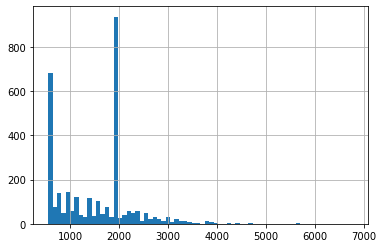

In [123]:
df_total['total_bill'].hist(bins=70)

In [124]:
df_total['total_bill'].describe()

count    3216.000000
mean     1528.902674
std       798.224060
min       550.000000
25%       750.000000
50%      1653.500000
75%      1950.000000
max      6770.000000
Name: total_bill, dtype: float64

In [125]:
df_total['total_bill'].isna().sum() # смотрим сколько пустых значений в 'total_bill'

0

меняем пустые на ноль

In [126]:
df_total['total_bill'].fillna(0, inplace=True)

In [127]:
df_total['total_bill'].isna().sum()

0

Выделяем из общей таблицы выручку пользователей тарифа Ультра

In [128]:
df_gipoteza_mean_bill_ultra = df_total[df_total['tariff'] == 'ultra']

df_gipoteza_mean_bill_ultra = df_gipoteza_mean_bill_ultra['total_bill']
display(df_gipoteza_mean_bill_ultra.head())

0    1950.0
1    1950.0
2    1950.0
3    1950.0
4    1950.0
Name: total_bill, dtype: Float64

Выделяем из общей таблицы выручку пользователей тарифа Смарт

interested_value предполагаемое среднее, на равенство которому мы делаем тест.
берем среднее тарифа смарт

In [129]:
df_gipoteza_mean_bill_smart = df_total[df_total['tariff'] == 'smart']
df_gipoteza_mean_bill_smart_mean = df_gipoteza_mean_bill_smart['total_bill'].mean()
display(df_gipoteza_mean_bill_smart_mean)
display(df_gipoteza_mean_bill_ultra.mean())

1289.6417040358745

2070.030425963489

In [130]:
df_gipoteza_mean_bill_smart = df_total[df_total['tariff'] == 'smart']
df_gipoteza_mean_bill_smart = df_gipoteza_mean_bill_smart['total_bill']
display(df_gipoteza_mean_bill_smart.head())

8     1150.0
9      550.0
10     550.0
11    1150.0
12    1550.0
Name: total_bill, dtype: Float64

In [131]:
alpha = .05 # критический уровень статистической значимости
            # если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(
    df_gipoteza_mean_bill_ultra, 
    df_gipoteza_mean_bill_smart)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")
    

p-значение: 8.081909555501892e-161
Отвергаем нулевую гипотезу


Интерпретация результата:
- с вероятностью очень близкой к нулю, выручка пользователей может быть равна

In [132]:
# Приведены два датасета: сумма покупок, совершённых за месяц посетителями ...

sample_1 = [3071, 3636, 3454, 3151, 2185, 3259, 1727, 2263, 2015,
2582, 4815, 633, 3186, 887, 2028, 3589, 2564, 1422, 1785,
3180, 1770, 2716, 2546, 1848, 4644, 3134, 475, 2686,
1838, 3352]
sample_2 = [1211, 1228, 2157, 3699, 600, 1898, 1688, 1420, 5048, 3007,
509, 3777, 5583, 3949, 121, 1674, 4300, 1338, 3066,
3562, 1010, 2311, 462, 863, 2021, 528, 1849, 255,
1740, 2596]
alpha = .05 # критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу
results = st.ttest_ind(
sample_1,
sample_2)
print('p-значение:', results.pvalue)
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.1912450522572209
Не получилось отвергнуть нулевую гипотезу


# Проверяем гипотезу двух стороннию что средняя выручка пользователей тарифов «Ультра» и «Смарт» различается; проверим на выборке из 50 элементов 

Сформулируем гипотезы:

- H0: Средняя выручка пользователей из Москвы равна от выручки пользователей из других регионов
- H1: Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов


In [133]:
df_total['city'].value_counts().head()

Москва             611
Санкт-Петербург    270
Новосибирск         98
Уфа                 95
Краснодар           86
Name: city, dtype: int64

In [134]:
df_gipoteza_mean_bill_smart_50 = df_gipoteza_mean_bill_smart[1 : 51]
df_gipoteza_mean_bill_ultra_50 = df_gipoteza_mean_bill_ultra[25:76]

In [135]:
alpha = .05 # критический уровень статистической значимости
            # если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(
    df_gipoteza_mean_bill_ultra_50, 
    df_gipoteza_mean_bill_smart_50)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 4.284739036717758e-23
Отвергаем нулевую гипотезу


Интерпретация результата:
- с вероятностью очень близкой к нулю, выручка пользователей может быть равна

Проверяем гипотезу что средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов проверим сразу на срезах из 50 элементов; - Формируем нулевую и альтернатвную гипотезу исходя из задания: Нулевая гипотеза: так как Нулевая гипотеза всегда формулируется так, чтобы использовать знак равенства То формулируем ее так: Средняя выручка пользователей из Москвы равна от выручки пользователей из других регионов; Исходя из нулевой гипотезы Альтернативная гипотеза: Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов;

Формируем таблицу из Московских абонентов берем выборку из 50 элементов

In [136]:
df_total['city'].value_counts().head()

Москва             611
Санкт-Петербург    270
Новосибирск         98
Уфа                 95
Краснодар           86
Name: city, dtype: int64

In [137]:
df_gipoteza_city_msk = df_total[df_total['city'] == 'Москва']
df_gipoteza_city_msk = df_gipoteza_city_msk['total_bill']
#df_gipoteza_city_msk_50 = df_gipoteza_city_msk[200:251]
display(df_gipoteza_city_msk)

8       1150.0
9        550.0
17      1950.0
18      1950.0
19      1950.0
         ...  
3120     950.0
3121     550.0
3122    1750.0
3123    1350.0
3124     750.0
Name: total_bill, Length: 611, dtype: Float64

Формируем таблицу из пользователей из других регионов и берем выборку из 50 элементов

In [138]:
df_gipoteza_city_not_msk = df_total[df_total['city'] != 'Москва']
df_gipoteza_city_not_msk = df_gipoteza_city_not_msk['total_bill']
#df_gipoteza_city_not_msk_50 = df_gipoteza_city_not_msk[2000:2051]
display(df_gipoteza_city_not_msk)

0       1950.0
1       1950.0
2       1950.0
3       1950.0
4       1950.0
         ...  
3211    1550.0
3212    1150.0
3213     950.0
3214    1950.0
3215     550.0
Name: total_bill, Length: 2605, dtype: Float64

In [139]:
alpha = .05 # критический уровень статистической значимости
            # если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(
    df_gipoteza_city_msk, 
    df_gipoteza_city_not_msk)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.54007516145112
Не получилось отвергнуть нулевую гипотезу


In [140]:
display(df_total)

,index,user_id,month,call_sum,call_mean,inter_sum,inter_mean,mess_sum,city,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_mb,rub_per_message,rub_per_minute,minutes_paid,internet_paid,message_paid,total_bill
0,0,1000,5,159,9.352941,2253.49,563.372500,22,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0,0.0,0,1950.0
1,1,1000,6,172,6.142857,23233.77,528.040227,60,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0,0.0,0,1950.0
2,2,1000,7,340,8.292683,14003.64,500.130000,75,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0,0.0,0,1950.0
3,3,1000,8,408,9.714286,14055.93,520.590000,81,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0,0.0,0,1950.0
4,4,1000,9,466,10.130435,14568.91,582.756400,57,Краснодар,ultra,1000,30720,3000,1950,150,1,1,0,0.0,0,1950.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,3211,1489,10,0,0.000000,19559.44,376.143077,21,Санкт-Петербург,smart,50,15360,500,550,200,3,3,0,1000.0,0,1550.0
3212,3212,1489,11,0,0.000000,17491.56,388.701333,20,Санкт-Петербург,smart,50,15360,500,550,200,3,3,0,600.0,0,1150.0
3213,3213,1489,12,0,0.000000,17322.51,402.849070,35,Санкт-Петербург,smart,50,15360,500,550,200,3,3,0,400.0,0,950.0
3214,3214,1128,0,0,0.000000,0.00,0.000000,0,Волжский,ultra,1000,30720,3000,1950,150,1,1,0,0.0,0,1950.0


Гипотеза не подтвердилать что и потдверждают наши вычесленные значения средних

Используем Гипотезу о равенстве средних двух генеральных совокупностей

Выделяем из общей таблицы выручку пользователей тарифа Смарт

Интерпретация результата:
- с вероятностью 54%, такой результат может быть получен случайно. 

In [141]:
df_gipoteza_city_msk_not_full_sum = df_total[df_total['city'] != 'Москва']
df_gipoteza_city_msk_not_full_sum['call_sum'].describe()

count    2605.000000
mean      446.698656
std       242.076254
min         0.000000
25%       280.000000
50%       440.000000
75%       584.000000
max      1673.000000
Name: call_sum, dtype: float64

In [142]:
df_gipoteza_city_msk_full_sum = df_total[df_total['city'] == 'Москва']
df_gipoteza_city_msk_full_sum['call_sum'].describe()

count     611.000000
mean      469.150573
std       241.535044
min         0.000000
25%       304.000000
50%       453.000000
75%       620.500000
max      1321.000000
Name: call_sum, dtype: float64

гипотеза возможно подтверждена

# Шаг 5. Oбщий вывод

При обработке данных:

- Исправлен формат даты, в данных смс заменены пропуски данных на нули

Рекомендации:

- вносить дату в правильном формате
- в случае нулевого количества смс вносить ноль а не оставлять пропуск

При анализе данных выявленно:

- Средняя продолжительность разговора выше на тарифе "Ультра" примерно на 20%
- Количество смс на тарифе "Ультра" выше почти на 50-60%
- Также количество интеренет трафика не намного больше в среднем на тарифе "Ультра" примерно на 10%
- Наиболее распостранена длительность на тарифе "Смарт" 450-500 минут разговоров в месяц и в случае тарифа "Ультра" наибольшая длительность очень растянута и достигает от 250 - 800 минут достигая небольшого пика в 500 мин
- На тарифе "Ультра клиенты раговаривают дольше чем на "Смарте"
- В основном клиенты отправляют не очень большшое количество смс для обоих тарифов это до 10 в месяц
- Наибольшее количество клиентов тарифа "Смарт" потребляют 15 - 20 Гб в месяц, для тарифа "Ультра" этот показатель ровно распределяется от 10 до 30 Гб Рекомендации:
- мы видим что 3000 минут на тарифе смарт явно избыточное предоложение и может быть сокращено без ущерба для пользователей впрочем судя по стабильному наращиванию клиентской базы возможно данное предложение дает неплохую привлекательность и немять ее не стоит чтобы не отпугнуть клиентов
- может быть стоит увеличить количество бесплатного траффика до 35 Гб сделав тариф более привлекательным для абонентов потребляющих большое количество трафика.

Проверка гипотез:
- средняя выручка пользователей тарифов «Ультра» и «Смарт» различается; Подтвердилась
- средняя выручка пользователей из Москвы равна выручки пользователей из других регионов; подтвердилась 

Вывод:
Оба тарифа приносят прибыль, в расчете на одного клиента ; прибыль тарифа Ультра выше, но валовую выручку больше приносит тариф смарт.

Тарифы исходя из разницы количества пользователей используют абоненты разных целевых аудиторий, например с разным уровнем дохода. 

Не целесобразно закрывать ни один из тарифов. 

Рекомендации:

- мы видим,  что 3000 минут на тарифе ультра явно избыточное предложение и может быть сокращено без ущерба для пользователей впрочем судя по стабильному наращиванию клиентской базы возможно данное предложение дает неплохую привлекательность и менять ее не стоит чтобы не отпугнуть клиентов

- может быть стоит увеличить количество бесплатного траффика до 35 Гб сделав в тарифе Ультра тариф более привлекательным для абонентов потребляющих большое количество трафика.
- Также судя по средней выручке в МСК и регионах рекомендуется углубить экспансию в регионы которые в среднем приносят сравнимую с МСК прибыль.